<a href="https://colab.research.google.com/github/aimachaudhry/nhanes_inferential_2021_23/blob/main/nhanes_inferential_2021_23__python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway, pearsonr, ttest_ind

In [8]:
from google.colab import files
uploaded = files.upload()

Saving BPXO_L.xpt to BPXO_L (1).xpt
Saving DEMO_L.xpt to DEMO_L (3).xpt
Saving HEPB_S_L.xpt to HEPB_S_L (1).xpt
Saving KIQ_U_L.xpt to KIQ_U_L (1).xpt
Saving PAQ_L.xpt to PAQ_L (1).xpt
Saving VID_L.xpt to VID_L (1).xpt
Saving WHQ_L.xpt to WHQ_L (1).xpt


In [16]:
# Load Files
demo = pd.read_sas('/content/DEMO_L (3).xpt', format='xport')
bpx  = pd.read_sas('/content/BPXO_L (1).xpt', format='xport')
vid  = pd.read_sas('/content/VID_L (1).xpt', format='xport')
hepb = pd.read_sas('/content/HEPB_S_L (1).xpt', format='xport')
kiq  = pd.read_sas('/content/KIQ_U_L (1).xpt', format='xport')
paq  = pd.read_sas('/content/PAQ_L (1).xpt', format='xport')
whq  = pd.read_sas('/content/WHQ_L (1).xpt', format='xport')

In [17]:
# Merge all datasets on SEQN
df = demo.merge(bpx, on='SEQN', how='left') \
         .merge(vid, on='SEQN', how='left') \
         .merge(hepb, on='SEQN', how='left') \
         .merge(kiq, on='SEQN', how='left') \
         .merge(paq, on='SEQN', how='left') \
         .merge(whq, on='SEQN', how='left')

In [19]:
# Preview the merged dataset
print("Merged dataset shape:", df.shape)
df.head(5)

Merged dataset shape: (11933, 68)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,PAD790U,PAD800,PAD810Q,PAD810U,PAD820,PAD680,WHD010,WHD020,WHD050,WHQ070
0,130378.0,12.0,2.0,1.0,43.0,NaN,5.0,6.0,2.0,NaN,...,b'W',45.0,3.000000e+00,b'W',45.0,360.0,71.0,190.0,200.0,1.0
1,130379.0,12.0,2.0,1.0,66.0,NaN,3.0,3.0,2.0,NaN,...,b'W',45.0,3.000000e+00,b'W',45.0,480.0,70.0,220.0,220.0,2.0
2,130380.0,12.0,2.0,2.0,44.0,NaN,2.0,2.0,1.0,NaN,...,b'W',20.0,5.397605e-79,b'',NaN,240.0,60.0,150.0,165.0,1.0
3,130381.0,12.0,2.0,2.0,5.0,NaN,5.0,7.0,1.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,130382.0,12.0,2.0,1.0,2.0,NaN,3.0,3.0,2.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Recode Marital Status
df['married'] = df['DMDMARTZ'].replace({
    1: 'Married',         # Married / Living with partner
    2: 'Not married',     # Widowed/Divorced/Separated
    3: 'Not married',     # Never married
    77: np.nan,           # Refused
    99: np.nan,           # Don't know
    '.': np.nan           # Missing
})
# Check results
df['married'].value_counts(dropna=False)


,count
married,
NaN,4150
Married,4136
Not married,3647


In [39]:
# Recode Education Level
df['education'] = df['DMDHREDZ'].replace({
    1: 'Less than bachelor',
    2: 'Less than bachelor',
    3: 'Bachelor+',
    '.': np.nan
})
# Check results
df['education'].value_counts(dropna=False)

,count
education,
NaN,8187
Less than bachelor,2554
Bachelor+,1192


In [46]:
# Recode Vitamin D Lab Interpretation
df['vitamin_d'] = df['LBDVD2LC'].apply(
    lambda x: 'Sufficient' if pd.notnull(x) and x < 1e-5
              else ('Deficient' if x == 1 else np.nan)
)

# Check results
df['vitamin_d'].value_counts(dropna=False)





,count
vitamin_d,
Deficient,5860
NaN,4626
Sufficient,1447


In [47]:
# Recode Hepatitis B Surface Antibody
df['hepb'] = df['LBXHBS'].apply(
    lambda x: 'Positive' if x == 1 else ('Negative' if x == 2 else np.nan)
)

# Check results
df['hepb'].value_counts(dropna=False)

,count
hepb,
Negative,5324
NaN,4567
Positive,2042


In [48]:
# Recode Weak/Failing Kidneys
df['kidney'] = df['KIQ022'].apply(
    lambda x: 'Yes' if x == 1 else ('No' if x == 2 else np.nan)
)

# Check results
df['kidney'].value_counts(dropna=False)

,count
kidney,
No,7473
NaN,4139
Yes,321


In [49]:
# Clean Minutes of Sedentary Behavior
# Remove placeholder values 7777, 9999, and missing values

df['sedentary'] = df['PAD680'].replace([7777, 9999], np.nan).apply(
    lambda x: 0 if pd.notnull(x) and x < 1e-5 else x
)

# Check results
df['sedentary'].describe()

,sedentary
count,8065.000000
mean,362.176069
std,210.026802
min,0.000000
25%,180.000000
50%,300.000000
75%,480.000000
max,1380.000000


In [51]:
# Clean Current Self-Reported Weight
# Remove placeholder values 7777, 9999, and missing values
df['weight'] = df['WHD020'].replace([7777, 9999], np.nan)

# Check results
df['weight'].describe()

,weight
count,8358.000000
mean,179.502273
std,48.115718
min,63.000000
25%,145.000000
50%,173.000000
75%,205.000000
max,530.000000


Contingency Table:
 education_level_recoded  Bachelor+  Less than bachelor
marital_status_recoded                                
Married                       1631                2503
Not married                    990                2648

Chi-square statistic = 129.17
P-value = 0.0000
Degrees of freedom = 1

Expected frequencies if independent:
education_level_recoded    Bachelor+  Less than bachelor
marital_status_recoded                                  
Married                  1394.134586         2739.865414
Not married              1226.865414         2411.134586

Result: The association is statistically significant (p < 0.05).


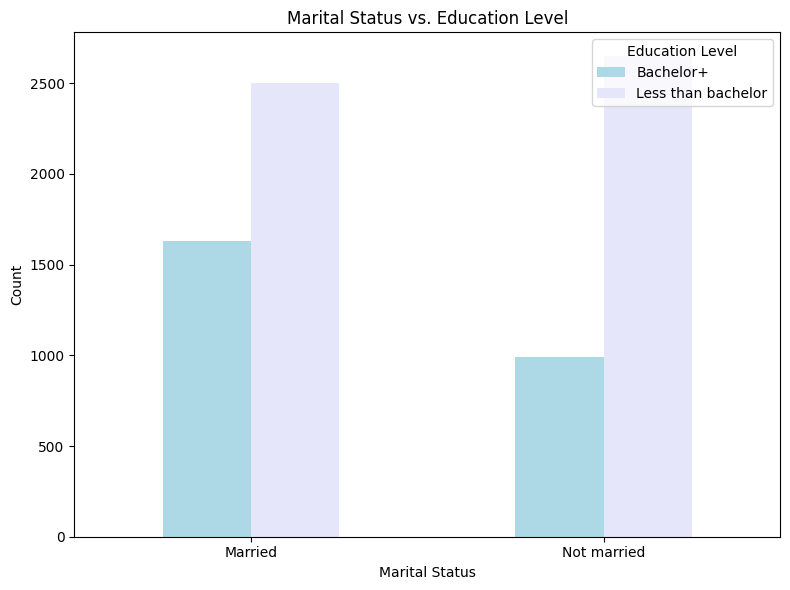

In [99]:
 # Association between marital status and education level

# Drop rows with NaN in either recoded column
df_chi = df[['marital_status_recoded', 'education_level_recoded']].dropna()

# Create contingency table
table = pd.crosstab(df_chi['marital_status_recoded'], df_chi['education_level_recoded'])
print("Contingency Table:\n", table)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(table)

print(f"\nChi-square statistic = {chi2:.2f}")
print(f"P-value = {p:.4f}")
print(f"Degrees of freedom = {dof}")
print("\nExpected frequencies if independent:")
print(pd.DataFrame(expected, index=table.index, columns=table.columns))

# Check significance
if p < 0.05:
    print("\nResult: The association is statistically significant (p < 0.05).")
else:
    print("\nResult: The association is not statistically significant (p ≥ 0.05).")

# Bar plot of the contingency table
table.plot(kind='bar', stacked=False, color=['lightblue', 'lavender'], figsize=(8,6))

plt.title('Marital Status vs. Education Level')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Education Level')
plt.tight_layout()
plt.show()


T-statistic = -3.85
P-value = 0.0001
Result: Significant difference in sedentary behavior between groups (p < 0.05)


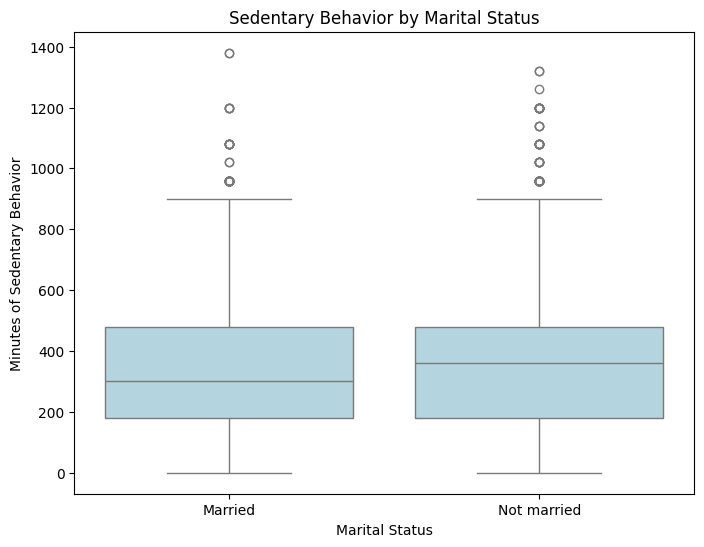

In [121]:
# Difference in mean sedentary behavior time by marital status
# Drop rows with NaN in either column
df_t = df[['married', 'sedentary']].dropna()


# Separate the two groups
married_group = df_t[df_t['married'] == 'Married']['sedentary']
not_married_group = df_t[df_t['married'] == 'Not married']['sedentary']

# Perform independent t-test
t_stat, p_val = ttest_ind(married_group, not_married_group, equal_var=False)

print(f"\nT-statistic = {t_stat:.2f}")
print(f"P-value = {p_val:.4f}")

# Check significance
if p_val < 0.05:
    print("Result: Significant difference in sedentary behavior between groups (p < 0.05)")
else:
    print("Result: No significant difference between groups (p ≥ 0.05)")

# Filter out 'Unknown' marital status
df_t_filtered = df_t[df_t['married'].isin(['Married', 'Not married'])]

# Box Plot
plt.figure(figsize=(8,6))
sns.boxplot(x='married', y='sedentary', data=df_t_filtered, color ='lightblue')
plt.ylabel('Minutes of Sedentary Behavior')
plt.xlabel('Marital Status')
plt.title('Sedentary Behavior by Marital Status')
plt.show()

Correlation between Age and Systolic BP: r = 0.51, p = 0.0000


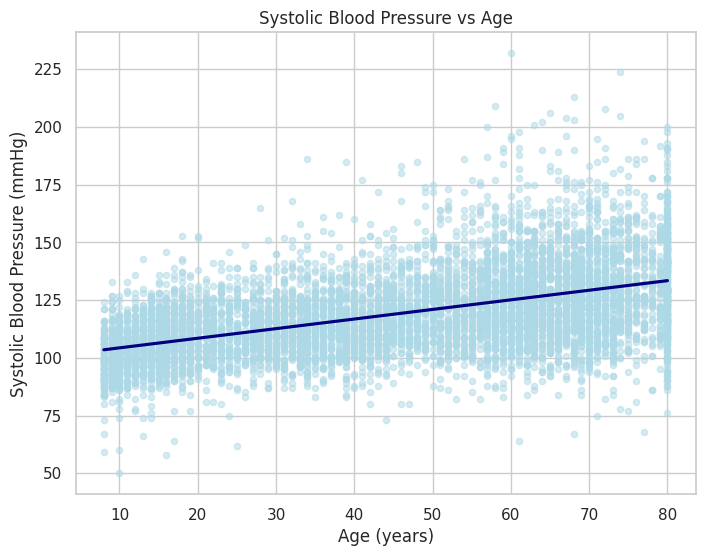


T-test between Married and Not Married Systolic BP: t = -0.53, p = 0.5954


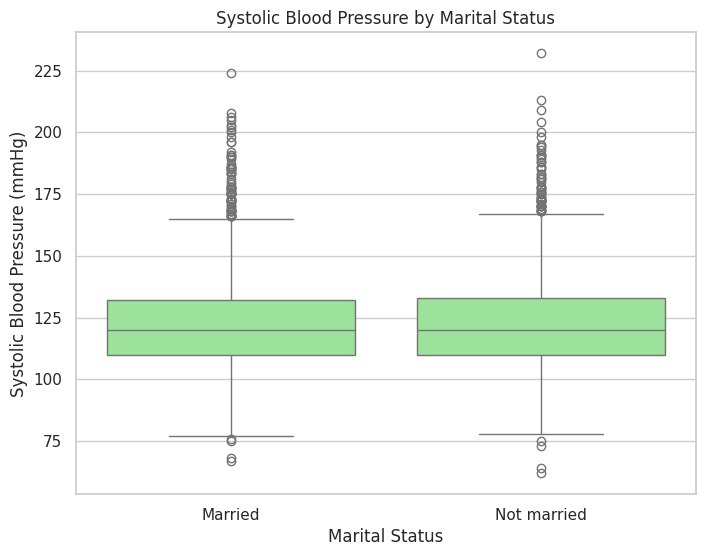


Interpretation:
- Age is significantly correlated with systolic BP (r = 0.51, p = 0.0000). BP tends to increase with age.
- No significant difference in systolic BP by marital status (t = -0.53, p = 0.5954).


In [148]:
# Age vs Systolic Blood Pressure
df_age_bp = df[['RIDAGEYR', 'BPXOSY3']].dropna()

# Correlation
r_age, p_age = pearsonr(df_age_bp['RIDAGEYR'], df_age_bp['BPXOSY3'])
print(f"Correlation between Age and Systolic BP: r = {r_age:.2f}, p = {p_age:.4f}")

# Scatter plot with regression line
plt.figure(figsize=(8,6))
sns.regplot(
    x='RIDAGEYR',
    y='BPXOSY3',
    data=df_age_bp,
    line_kws={'color':'navy'},
    scatter_kws={'alpha': 0.5, 's': 20, 'color': 'lightblue'}
)
plt.xlabel('Age (years)')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.title('Systolic Blood Pressure vs Age')
plt.show()

# Marital Status vs Systolic Blood Pressure
df_married_bp = df[['married', 'BPXOSY3']].dropna()


# T-test: Married vs Not Married
bp_married = df_married_bp[df_married_bp['married']=='Married']['BPXOSY3']
bp_not_married = df_married_bp[df_married_bp['married']=='Not married']['BPXOSY3']
t_stat, p_married = ttest_ind(bp_married, bp_not_married, equal_var=False)

print(f"\nT-test between Married and Not Married Systolic BP: t = {t_stat:.2f}, p = {p_married:.4f}")

# Filter out 'Unknown' from the 'married' column for the boxplot and t-test data
df_married_bp = df_married_bp[df_married_bp['married'] != 'Unknown']

# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='married', y='BPXOSY3', data=df_married_bp, color ='lightgreen')
plt.xlabel('Marital Status')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.title('Systolic Blood Pressure by Marital Status')
plt.show()

# Interpretation
print("\nInterpretation:")
if p_age < 0.05:
    print(f"- Age is significantly correlated with systolic BP (r = {r_age:.2f}, p = {p_age:.4f}). BP tends to increase with age.")
else:
    print(f"- No significant correlation between age and systolic BP (r = {r_age:.2f}, p = {p_age:.4f}).")

if p_married < 0.05:
    print(f"- Marital status is significantly associated with systolic BP (t = {t_stat:.2f}, p = {p_married:.4f}).")
else:
    print(f"- No significant difference in systolic BP by marital status (t = {t_stat:.2f}, p = {p_married:.4f}).")

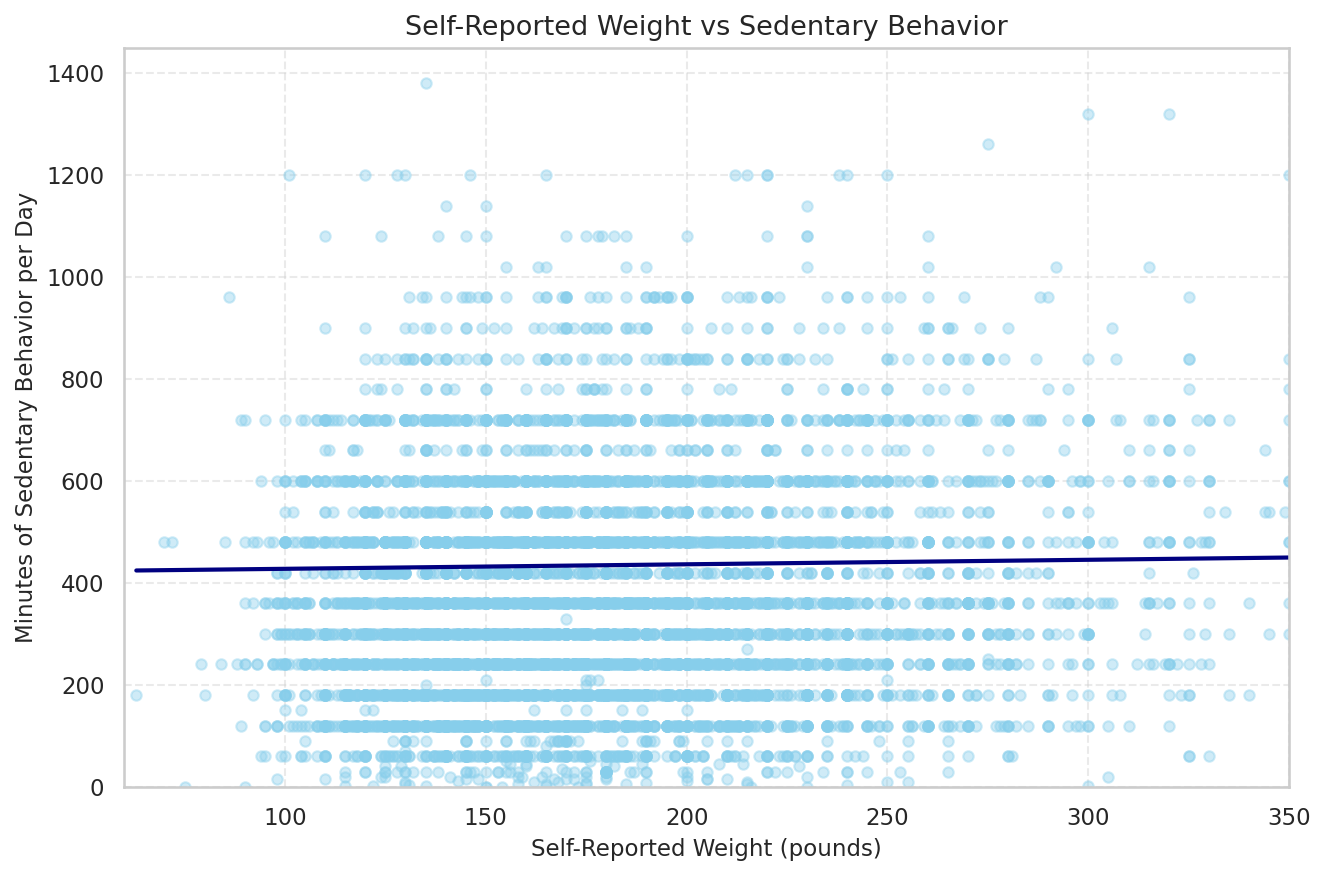

Pearson correlation coefficient (r): 0.105
P-value: 0.0000
- There is a statistically significant relationship between weight and sedentary behavior
- Positive correlation


In [174]:
# Self-Reported Weight vs Sedentary Behavior

# Drop missing values
df_corr = df[['WHD020', 'PAD680']].dropna()

# Compute Pearson correlation
r_value, p_value = pearsonr(df_corr['WHD020'], df_corr['PAD680'])

# Scatterplot with regression line
plt.figure(figsize=(9,6), dpi=150)
sns.regplot(
    x='WHD020',
    y='PAD680',
    data=df_corr,
    scatter_kws={'alpha':0.4, 's':25, 'color':'skyblue'},
    line_kws={'color':'navy', 'lw':2},
    ci=None
)

# Axis limits
plt.xlim(60, 350)
plt.ylim(0, 1450)

plt.title('Self-Reported Weight vs Sedentary Behavior', fontsize=13)
plt.xlabel('Self-Reported Weight (pounds)', fontsize=11)
plt.ylabel('Minutes of Sedentary Behavior per Day', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Print correlation results
print(f"Pearson correlation coefficient (r): {r_value:.3f}")
print(f"P-value: {p_value:.4f}")

#Analysis

if p_value < 0.05:
    print("- There is a statistically significant relationship between weight and sedentary behavior")
else:
    print("- There is no statistically significant relationship between weight and sedentary behavior")

if r_value > 0:
    print("- Positive correlation")
elif r_value < 0:
    print("- Negative correlation")
else:
    print("- No correlation detected.")



ANOVA F-statistic = 3.50, p-value = 0.0615

Interpretation:
- There is no statistically significant difference in sedentary behavior by Vitamin D status.


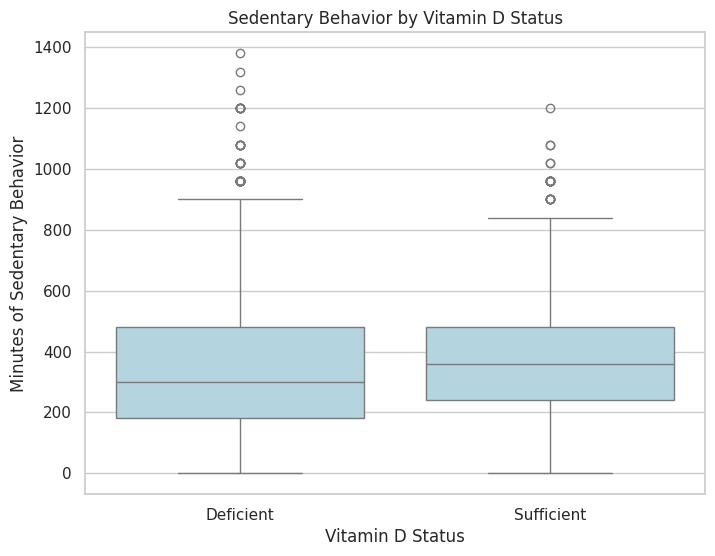

In [178]:
# Effect of Vitamin D Status on Sedentary Behavior

# Drop missing values
df_anova = df[['vitamin_d', 'sedentary']].dropna()

# ANOVA test
groups = [df_anova['sedentary'][df_anova['vitamin_d'] == level] for level in df_anova['vitamin_d'].unique()]
f_stat, p_value = f_oneway(*groups)

print(f"\nANOVA F-statistic = {f_stat:.2f}, p-value = {p_value:.4f}")

# Interpretation
print("\nInterpretation:")
if p_value < 0.05:
    print("- There is a statistically significant difference in sedentary behavior by Vitamin D status.")
else:
    print("- There is no statistically significant difference in sedentary behavior by Vitamin D status.")

# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x='vitamin_d', y='sedentary', data=df_anova, color ='lightblue')
plt.xlabel('Vitamin D Status')
plt.ylabel('Minutes of Sedentary Behavior')
plt.title('Sedentary Behavior by Vitamin D Status')
plt.show()
